**Goal: To predict the price of diamonds based on their characteristics**

**Libraries**

In [21]:
# for operation
import pandas as pd

# for visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (8, 4)})
sns.set_style('whitegrid')

---

# Import

In [4]:
# importing clean dataset
diamonds = pd.read_csv('../dataset/diamonds_clean.csv', index_col = 'id')

In [7]:
# checking
diamonds.sample()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
4313,0.74,4,4,3,60.5,59.0,5.81,5.86,3.53,7.985


# Check ML models

1. Find which is the best model - include crossvalidation
2. Feature Selection to remove the ones that do not affect the price
3. Change parameters to minimze RMSE -> split size, change values in categoricals

In [11]:
# defining sets
X = diamonds[["carat", "cut", "color", "clarity", "depth", "table", "x", "y", "z"]]
y = diamonds["price"]

## Considering all features

### Lazy Predict

In [20]:
# lets first try lazypredict: doesn't consider hyperparameter tuning

from lazypredict.Supervised import LazyRegressor

offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

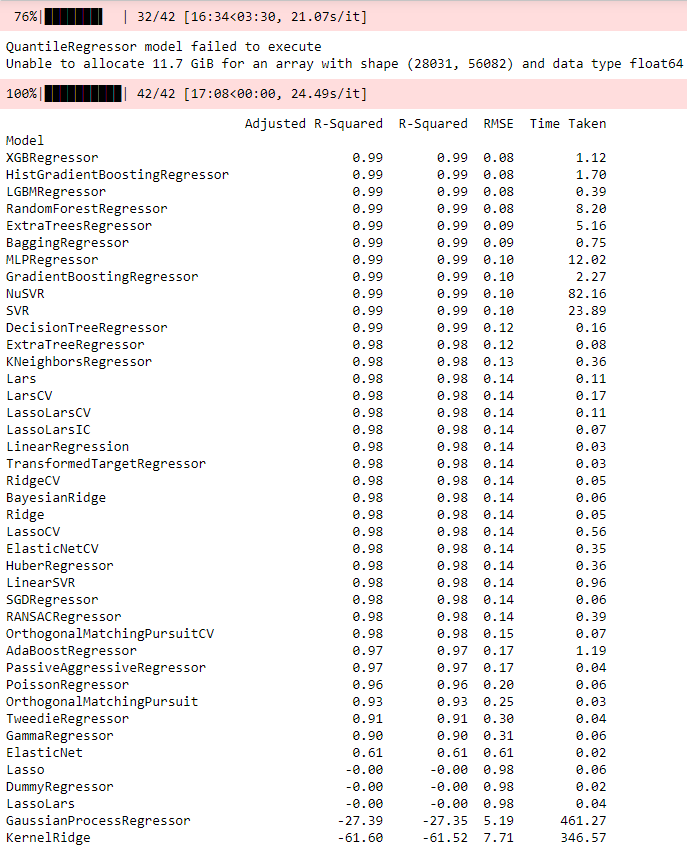

### h2o AutoML

In [23]:
# start h2o

import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from C:\Users\mplan\anaconda3\envs\Ironhack\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\mplan\AppData\Local\Temp\tmpd8vwt3a_
  JVM stdout: C:\Users\mplan\AppData\Local\Temp\tmpd8vwt3a_\h2o_mplan_started_from_python.out
  JVM stderr: C:\Users\mplan\AppData\Local\Temp\tmpd8vwt3a_\h2o_mplan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_mplan_n52bnn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.516 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [25]:
# Load data into H2O

df = h2o.import_file('../dataset/diamonds_clean.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [30]:
df = df.drop(['id'], axis=1) # dropping the 'id' column

In [33]:
df.head(5)

carat,cut,color,clarity,depth,table,x,y,z,price
1.02,1,6,3,63.2,58,6.36,6.4,4.03,8.928
0.35,2,2,5,61,57,4.54,4.57,2.77,6.477
0.31,3,2,6,60.5,58,4.43,4.4,2.67,6.81
0.38,4,5,4,61.4,56,4.66,4.69,2.87,6.824
1.64,4,3,5,61.8,56,7.59,7.6,4.69,9.776


In [34]:
y = "price" # define variable to predict

In [35]:
splits = df.split_frame(ratios = [0.8], seed = 1) # split the data into 80% (train) and 20% (test)
train = splits[0]
test = splits[1]

***from the docs***

Run AutoML, stopping after 60 seconds. The max_runtime_secs argument provides a way to limit the AutoML run by time. When using a time-limited stopping criterion, the number of models train will vary between runs. If different hardware is used or even if the same machine is used but the available compute resources on that machine are not the same between runs, then AutoML may be able to train more models on one run vs another.

In [36]:
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "diamonds_automl")
aml.train(y = y, training_frame = df)

AutoML progress: |
17:10:04.436: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0590247,0.0001447,0.0590643,0.0587990,0.0591897,0.0590789,0.0589915
mean_residual_deviance,0.0066884,0.0001912,0.0070179,0.0065789,0.0066953,0.0065744,0.0065757
mse,0.0066884,0.0001912,0.0070179,0.0065789,0.0066953,0.0065744,0.0065757
null_deviance,6641.482,89.364426,6514.9204,6646.7812,6694.406,6749.0063,6602.295
r2,0.9929388,0.0002776,0.9924764,0.9930972,0.992899,0.9931765,0.9930451
residual_deviance,46.871006,1.373003,48.991817,45.881096,47.53664,46.027283,45.918198
rmse,0.0817762,0.0011601,0.0837728,0.0811103,0.0818248,0.0810826,0.0810908
rmsle,0.0094271,0.0001210,0.0096302,0.0093742,0.0094449,0.0093467,0.0093394


In [37]:
aml.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20230126_171004,0.0817827,0.00668841,0.0590253,0.0094277,0.00668841
StackedEnsemble_AllModels_2_AutoML_1_20230126_171004,0.0817838,0.00668859,0.0590258,0.00942781,0.00668859
GBM_4_AutoML_1_20230126_171004,0.0818098,0.00669284,0.0590172,0.00943082,0.00669284
StackedEnsemble_BestOfFamily_3_AutoML_1_20230126_171004,0.0818269,0.00669564,0.0590677,0.00943323,0.00669564
StackedEnsemble_BestOfFamily_2_AutoML_1_20230126_171004,0.0818302,0.00669618,0.0590783,0.00943358,0.00669618
StackedEnsemble_AllModels_3_AutoML_1_20230126_171004,0.0819485,0.00671556,0.0593295,0.00945363,0.00671556
GBM_3_AutoML_1_20230126_171004,0.0820467,0.00673166,0.0596624,0.00947957,0.00673166
GBM_2_AutoML_1_20230126_171004,0.0827527,0.00684802,0.0603549,0.00957156,0.00684802
GBM_1_AutoML_1_20230126_171004,0.08288,0.00686909,0.0603122,0.00957377,0.00686909
StackedEnsemble_BestOfFamily_1_AutoML_1_20230126_171004,0.0829029,0.0068729,0.0603834,0.0095773,0.0068729


With h2o AutoML we found a model with RMSE 0.0067, much better than the XGBRegressor model from Lazy Predict (RMSE 0.08), although there is not hyperarameter tunning there.

In [39]:
# get the leader
leader = aml.leader

In [40]:
leader

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0590247,0.0001447,0.0590643,0.0587990,0.0591897,0.0590789,0.0589915
mean_residual_deviance,0.0066884,0.0001912,0.0070179,0.0065789,0.0066953,0.0065744,0.0065757
mse,0.0066884,0.0001912,0.0070179,0.0065789,0.0066953,0.0065744,0.0065757
null_deviance,6641.482,89.364426,6514.9204,6646.7812,6694.406,6749.0063,6602.295
r2,0.9929388,0.0002776,0.9924764,0.9930972,0.992899,0.9931765,0.9930451
residual_deviance,46.871006,1.373003,48.991817,45.881096,47.53664,46.027283,45.918198
rmse,0.0817762,0.0011601,0.0837728,0.0811103,0.0818248,0.0810826,0.0810908
rmsle,0.0094271,0.0001210,0.0096302,0.0093742,0.0094449,0.0093467,0.0093394


In [41]:
# save the model
h2o.save_model(model = leader, path ='./models/', force = True)

'C:\\Users\\mplan\\Ironhack\\Bootcamp\\project-5\\project-5\\src\\models\\StackedEnsemble_AllModels_1_AutoML_1_20230126_171004'

In [51]:
# try yo make prediction on the same data
pred = leader.predict(df)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
8.83306
6.53481
6.80469
6.87042
9.7344
9.37925
8.24233
8.55514
6.72642
8.08793


In [58]:
df['price'].head()

price
8.928
6.477
6.81
6.824
9.776
9.316
8.292
8.568
6.75
8.081


## Feature selection

## Considering selected features only